In [ ]:
import pandas as pd
import re
import numpy as np
import gensim

In [ ]:
!ls "/content/drive/MyDrive/mallet-2.0.8.zip"

/content/drive/MyDrive/mallet-2.0.8.zip


In [ ]:
!unzip -q "/content/drive/MyDrive/mallet-2.0.8.zip"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cards.csv',sep=';')
df

,article,fit_back,stars
0,"Снова мошенничество, на этот страховку вернули...",Ранее писал отзыв о мошенническом навязывании ...,1
1,ОТП Банк отказывается принимать отказ от навяз...,Добрый день. Хочу оставить жалобу на вашего со...,2
2,Мошенничество,Добрый день прошу пояснить мне причину запроса...,1
3,невозможно вернуть вклад,вклад 200.0 т.р невозможно вернуть в короткие ...,1
4,Кредит,Сегодня был в офисе банка ОТП по ул.Бабушкина ...,5
...,...,...,...
7580,Мне нравится!,"Давно уже слышал об этом банке, но все было не...",5
7581,Неплохой банк,"Что меня привлекает в этом банке, так это его ...",5
7582,Полный бред,"1 Приехал окрыть вклад ""Лидер"" на Павелецкой. ...",1
7583,Рекомендую!,"В этом банке я обслуживаюсь более десяти лет, ...",5


In [ ]:
df=df[df['stars']< 2]
df=df.iloc[:4000,:]

In [ ]:
data = df.fit_back.to_list()

In [ ]:
! pip install pymorphy2

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 8.2MB 5.6MB/s 


In [ ]:
import nltk
nltk.download("stopwords")
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.corpus import stopwords
import re, string
from nltk.stem.snowball import SnowballStemmer

russian_stopwords = stopwords.words("russian") + ['банк','ОТП',"отп","добрый","день","итоге","сих","пор","вопрос","это","мочь","все"] # собираем стоп слова
regex = re.compile('[%s]' % re.escape(string.punctuation))
stemmer = SnowballStemmer("russian")

def preprocessing(text):
    text = regex.sub('', text) 
    text = [pymorphy2_analyzer.parse(token) for token in text.split()]
    text = [token[0].normal_form.lower() for token in text ] 
    text = [token for token in text if token not in russian_stopwords and len(token)>=4] 
  
    return ' '.join(text)


preprocessing("я вы он и мы, футбол, люблю, кредитный !")


'футбол любить кредитный'

In [ ]:
df['fit_back'] = df['fit_back'].apply(lambda x: preprocessing(x))

In [ ]:
text_clean= []
for index, row in df.iterrows():
        text_clean.append(row['fit_back'].split())

from gensim.models import Phrases
bigram = Phrases(text_clean) # Создаем биграммы на основе корпуса
trigram = Phrases(bigram[text_clean])# Создаем триграммы на основе корпуса

for idx in range(len(text_clean)):
    for token in bigram[text_clean[idx]]:
        if '_' in token:
            # Токен это би грамма, добавим в документ.
            text_clean[idx].append(token)
    for token in trigram[text_clean[idx]]:
        if '_' in token:
			# Токен это три грамма, добавим в документ.
			      text_clean[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
from gensim.models import *
from gensim import corpora
from gensim import similarities

In [ ]:
# почему бы не doc2vec?

print('Making dictionary...')
dictionary = corpora.Dictionary(text_clean)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.9, keep_n=None)
dictionary.save('polkrug.dict')
print('Filtered: {}'.format(dictionary))

print('Vectorizing corpus...')
corpus = [dictionary.doc2bow(text) for text in text_clean]
corpora.MmCorpus.serialize('polkrug.model', corpus) 

Making dictionary...
Original: Dictionary(36891 unique tokens: ['0707', '12000', '15712', '27042021', '28042021']...)
Filtered: Dictionary(6679 unique tokens: ['0707', '12000', 'bankiru', 'апрель', 'безналичный']...)
Vectorizing corpus...


In [ ]:
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
	Подсчет c_v когерентности для различного количества тем
	dictionary : Gensim словарь
	corpus : Gensim корпус.
	texts : Список текста
	limit : Максимальное количество тем
	
	model_list : Список LDA моделей
	coherence_values :Когерентности, соответствующие модели LDA с количеством тем
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model=ldamodel.LdaModel(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	
# Вызовем функцию и посчитаем
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_clean, start=2, limit=40, step=2)

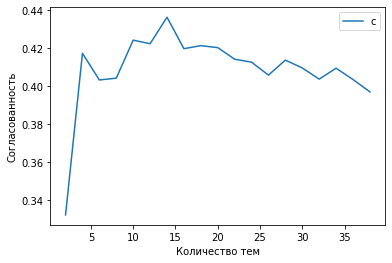

In [ ]:
import matplotlib.pyplot as plt
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
print("Training model...")

lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, chunksize=50, update_every=1, passes=2)

Training model...


In [ ]:
import gensim
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=dictionary)

In [ ]:
print(ldamallet.show_topics(formatted=False))

[(0, [('номер', 0.018704680290046145), ('звонок', 0.01514090309822017), ('кредитный', 0.014625906394199077), ('дать', 0.012720418589321028), ('кредитный_история', 0.012442320369149638), ('сотрудник', 0.01152562623599209), ('обращение', 0.010845830586684245), ('телефон', 0.00896094264996704), ('который', 0.008950642715886619), ('номер_телефон', 0.0088476433750824)]), (1, [('сказать', 0.018890507427235362), ('горячий_линия', 0.01831525621874391), ('отделение', 0.013509125154250828), ('говорить', 0.012776143775689142), ('линия', 0.011161729093793782), ('сотрудник', 0.010762764545969066), ('свой', 0.010438025960530345), ('горячий', 0.010391634734039099), ('звонить', 0.009974113695617884), ('клиент', 0.009584427393091418)]), (2, [('кредит', 0.03541191194875948), ('сумма', 0.03333999432063188), ('платёж', 0.02579905554211672), ('месяц', 0.017311555410649868), ('деньга', 0.016512236934823992), ('рубль', 0.01393548658512216), ('процент', 0.011947707743923602), ('счёт', 0.011022181087704168), (

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
def plotWordCloud(topic_number):
  text = dict(ldamallet.show_topics(formatted=False)[topic_number][1])
  wordcloud = WordCloud(background_color='white',max_words=100,width=900,height=900,collocations=False)
  wordcloud = wordcloud.generate_from_frequencies(text)
  plt.figure(figsize=(15,10))
  plt.title("Топик номер {}".format(topic_number))
  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis('off')

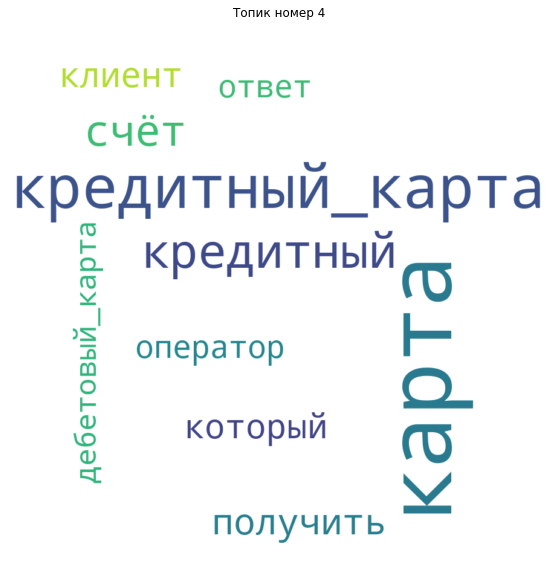

In [ ]:
plotWordCloud(4)

In [ ]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3109,"кредит, сумма, платёж, месяц, деньга, рубль, п...",Ранее писал отзыв о мошенническом навязывании ...
1,1,0.0,0.3059,"номер, звонок, кредитный, дать, кредитный_исто...",Добрый день прошу пояснить мне причину запроса...
2,2,1.0,0.3029,"сказать, горячий_линия, отделение, говорить, л...",вклад 200.0 т.р невозможно вернуть в короткие ...
3,3,4.0,0.3548,"карта, кредитный_карта, кредитный, счёт, получ...","Т.к. закрываю кредитные карты всех банков, реш..."
4,4,0.0,0.2547,"номер, звонок, кредитный, дать, кредитный_исто...","Обратилась в офис по адресу: г. Смоленск, ул. ..."
5,5,2.0,0.2665,"кредит, сумма, платёж, месяц, деньга, рубль, п...",24.04.21 подали заявление на погашение потреби...
6,6,1.0,0.3474,"сказать, горячий_линия, отделение, говорить, л...",Добрый день!Заказал на сайте Ситилинка ноутбук...
7,7,0.0,0.3267,"номер, звонок, кредитный, дать, кредитный_исто...","В декабре 2020 года ""посчастливилось"" одобрить..."
8,8,3.0,0.3841,"кредит, договор, заявление, страховка, сотрудн...",24.04.21 Мною был оформлен потребительский кре...
9,9,3.0,0.3762,"кредит, договор, заявление, страховка, сотрудн...",Номера сертификатов: ОТР-46011400/2021-3170276...


In [ ]:
df_dominant_topic[(df_dominant_topic['Dominant_Topic']==0.0) & (df_dominant_topic['Topic_Perc_Contrib']>0.5)].Text.to_list()[2]

'Самый не порядочный банк, что можно себе представить! Ситуация в следующем, есть потреб.кредит-платил испрано-началась пандемия-уволили с работы, пол года просил отсрочку платежей, спустя пол года её мне дали, за это время не успеваю устраиваться на работу наступает платёж я его исправно оплачиваю, при этом оставляю обращения на рестуктуризацию (потому что не устроился ещё на работу) ни чего не отвечает мне банк, в период с последней оплаты поворачивается работа и я уезжаю на вахту, подходит следующий платёж естественно деньги заработать я не успеваю и прсрачиваю пол месяца (уведомив банк об этом,но скрываюсь).После пол месяца просрочки начинает звонить коллектор (не после суда не после приставов), а спустя пол месяца просрочки (её можно назвать технической) и начинает мне угрожать, пояснив всю ситуацию звонки продолжаются я с ними общаюсь не игнарируя поясняю ситуацию! И уже готов был оплатить, так как получил первую зп эта женщина начинает звонить и рассылать смс чужим посторонним л

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Keywords','Text']]
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords','Text', 'Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Text,Num_Documents,Perc_Documents
0.0,1.0,"договор, кредит, заявление, страховка, написат...",Ранее писал отзыв о мошенническом навязывании ...,696.0,0.1740
1.0,4.0,"сумма, платёж, кредит, счёт, месяц, кредитный,...",Добрый день прошу пояснить мне причину запроса...,757.0,0.1892
2.0,3.0,"сказать, говорить, кредит, отделение, деньга, ...",вклад 200.0 т.р невозможно вернуть в короткие ...,868.0,0.2170
3.0,2.0,"карта, кредитный_карта, горячий_линия, кредитн...","Т.к. закрываю кредитные карты всех банков, реш...",813.0,0.2032
4.0,0.0,"номер, сотрудник, звонок, дать, телефон, звони...","Обратилась в офис по адресу: г. Смоленск, ул. ...",866.0,0.2165
...,...,...,...,...,...
3995.0,2.0,"карта, кредитный_карта, горячий_линия, кредитн...",В предыдущем месяце выполнил по карте условия ...,NaN,NaN
3996.0,1.0,"договор, кредит, заявление, страховка, написат...","Добрый день! Брал у вас экспресс кредит, плачу...",NaN,NaN
3997.0,0.0,"номер, сотрудник, звонок, дать, телефон, звони...","Добрый день, взяли кредит в магазине (2 предме...",NaN,NaN
3998.0,3.0,"сказать, говорить, кредит, отделение, деньга, ...",Вот уже более полугода я с большим трудом и по...,NaN,NaN


In [ ]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0.0,0.5113,"карта, кредитный_карта, платёж, счёт, сумма, к...",Ранее писал отзыв о мошенническом навязывании ...
1,1.0,0.9949,"кредит, сотрудник, договор, заявление, сказать...",Добрый день. Хочу оставить жалобу на вашего со...
2,0.0,0.8257,"карта, кредитный_карта, платёж, счёт, сумма, к...",Добрый день прошу пояснить мне причину запроса...
3,1.0,0.5895,"кредит, сотрудник, договор, заявление, сказать...",вклад 200.0 т.р невозможно вернуть в короткие ...
4,1.0,0.9556,"кредит, сотрудник, договор, заявление, сказать...","Уважаемы работники банка, очень прошу удалите ..."
...,...,...,...,...
3995,1.0,0.9928,"кредит, сотрудник, договор, заявление, сказать...",В течение последних 6-8 месяцев на принадлежащ...
3996,1.0,0.8293,"кредит, сотрудник, договор, заявление, сказать...",Сегодня решил воспользоваться услугой ОТП банк...
3997,1.0,0.5550,"кредит, сотрудник, договор, заявление, сказать...",Отвратительный банк! За такие выкрутасы в сове...
3998,1.0,0.9518,"кредит, сотрудник, договор, заявление, сказать...","Добрый вечер!Кочеткова Елена Вячеславовна, дог..."
